In [2]:
import pyodbc
import pandas as pd
import numpy as np

In [3]:
# Connection string (adjust server, user, pwd)
conn = pyodbc.connect(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=LAPTOP-KT5S5Q1A\SQLEXPRESS;"
    "Database=Retail_Analytics;"
    "Trusted_Connection=yes;"
)

In [4]:
import warnings
warnings.filterwarnings("ignore", message = "pandas only supports SQLAlchemy")

In [5]:
# Loading a sample of products table in Processed
products = pd.read_sql_query("SELECT * FROM instac_products", conn)
print("Products shape:", products.shape)
products.to_csv("E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\instac_products_sample.csv", index=False)

Products shape: (49688, 4)


In [6]:
# Loading a sample of aisles table in Processed
aisles = pd.read_sql_query("SELECT * FROM instac_aisles", conn)
print("Aisles shape:", aisles.shape)
aisles.to_csv("E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\instac_aisles_sample.csv", index=False)

Aisles shape: (134, 2)


In [7]:
# Loading a sample of departments table in Processed
depts = pd.read_sql_query("SELECT * FROM instac_departments", conn)
print("Departments shape:", depts.shape)
depts.to_csv("E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\instac_departments_sample.csv", index=False)

Departments shape: (21, 2)


In [8]:
# Loading a sample of orders table in Processed
orders = pd.read_sql_query("SELECT * FROM instac_orders", conn)
print("Orders shape: ", orders.shape)
orders.to_csv("E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\instac_orders_sample.csv", index=False)

Orders shape:  (3421083, 7)


In [9]:
# Loading a sample of walmart_data table in Processed
walmart_data = pd.read_sql_query("SELECT * FROM walmart_data", conn)
print("walmart_data shape:", walmart_data.shape)
walmart_data.to_csv("E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\walmart_data_sample.csv", index=False)

walmart_data shape: (6435, 8)


In [10]:
# Loading a sample of order_products_train table in Processed
order_products_train = pd.read_sql_query("SELECT * FROM instac_order_products__train", conn)
print("order_products_train shape:", order_products_train.shape)
order_products_train.to_csv("E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\instac_order_products_train_sample.csv", index=False)

order_products_train shape: (1384617, 4)


In [11]:
# Loading a sample of order_products_prior table (as it has 32M rows) in Processed
order_products_prior = pd.read_sql_query("""
    SELECT TOP 1384617 *
    FROM instac_order_products_prior
    ORDER BY NEWID();
""", conn)

print(order_products_prior.shape)
order_products_prior.to_csv("E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\instac_order_products_prior_sample.csv", index=False)

(1384617, 4)


In [12]:
print("✅ Data pulled from SQL and sample saved.")

✅ Data pulled from SQL and sample saved.


## Handling missing values

In [13]:
# Replacing NULLs (means customer's first order) with 0 (first order) in col.- days_since_prior_order
orders["days_since_prior_order"] = orders["days_since_prior_order"].fillna(0)

In [14]:
# forward fill -> backward fill to keep continuity (fiiling missing values with nearby values)

# for Temperature (1 mssing value)
walmart_data["Temperature"] = walmart_data["Temperature"].ffill().bfill()

#for Fuelprice ()
walmart_data["Fuel_Price"] = walmart_data["Fuel_Price"].ffill().bfill()

# for Unemployment ()
walmart_data["Unemployment"] = walmart_data["Unemployment"].ffill().bfill()

## Removing duplicates

In [15]:
# For order table
dup_present = orders.duplicated(subset=["order_id"]).sum()
print("Duplicate orders: ",dup_present)
dup = orders.drop_duplicates(subset=["order_id"], inplace=True)
print("Duplicate Orders: ",dup)

Duplicate orders:  0
Duplicate Orders:  None


In [16]:
# for order_products_train table
dup_prsnt = order_products_train.duplicated(subset=["order_id", "product_id"]).sum()
print("Duplicates: ",dup_prsnt)
dup = order_products_train.drop_duplicates(subset=["order_id", "product_id"], inplace=True)
print("Duplicates: ",dup)

Duplicates:  0
Duplicates:  None


In [17]:
# for order_products_prior table
dup_prsnt = order_products_prior.duplicated(subset=["order_id", "product_id"]).sum()
print("Duplicates: ",dup_prsnt)
dup = order_products_prior.drop_duplicates(subset=["order_id", "product_id"], inplace=True)
print("Duplicates: ",dup)

Duplicates:  0
Duplicates:  None


In [18]:
# for products table
dup_prsnt = products.duplicated(subset=["product_id"]).sum()
print("Duplicates: ",dup_prsnt)
dup = products.drop_duplicates(subset=["product_id"], inplace=True)
print("Duplicates: ",dup)

Duplicates:  0
Duplicates:  None


In [19]:
# for aisles table
dup_prsnt = aisles.duplicated(subset=["aisle_id"]).sum()
print("Duplicates: ",dup_prsnt)
dup = aisles.drop_duplicates(subset=["aisle_id"], inplace=True)
print("Duplicates: ",dup)

Duplicates:  0
Duplicates:  None


In [20]:
# for dept. table
dup_prsnt = depts.duplicated(subset=["department_id"]).sum()
print("Duplicates: ",dup_prsnt)
dup = depts.drop_duplicates(subset=["department_id"], inplace=True)
print("Duplicates: ",dup)

Duplicates:  0
Duplicates:  None


In [21]:
# for walmart_data table
dup_prsnt = walmart_data.duplicated(subset=["Store", "Date"]).sum()
print("Duplicates: ",dup_prsnt)
dup = walmart_data.drop_duplicates(subset=["Store", "Date"], inplace=True)
print("Duplicates: ",dup)

Duplicates:  0
Duplicates:  None


## Feature Engineering

### Instacart Order-level Metrics (KPIs baseline)

In [22]:
# joins or merge order_products_prior with product info (Enriching orders with product details) 
instacart = order_products_prior.merge(products, on="product_id", how="left")

# joins or merge orders table to bring user_id
instacart = instacart.merge(orders, on="order_id", how="left")

In [23]:
# Aggregate product_level orders into order_level summary
order_level = instacart.groupby("order_id").agg(
    user_id=("user_id", "first"),
    total_items=("product_id", "count"),
    reordered_items=("reordered", "sum")
).reset_index() 

order_level.shape

(1047219, 4)

In [24]:
# checking col names in instacart
print(instacart.columns)

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'user_id', 'eval_set',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order'],
      dtype='object')


In [25]:
order_items = pd.read_sql_query("SELECT * FROM instac_order_items_count", conn)
order_level_from_products = orders[orders["order_id"].isin(order_items["order_id"])].merge(order_items, on="order_id")
basket_size = order_level_from_products["total_items"].mean()
print("✅ Basket size (Instacart; from SQL-aggregated counts):", round(basket_size, 2))
print(order_level_from_products["total_items"].describe())

✅ Basket size (Instacart; from SQL-aggregated counts): 10.11
count    3.346083e+06
mean     1.010707e+01
std      7.542326e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: total_items, dtype: float64


In [26]:
total_customers = int(orders["user_id"].nunique())
print("Total Customers: ", total_customers)

Total Customers:  206209


In [27]:
total_orders = int(orders["order_id"].nunique())
print("Total Orders: ", total_orders)

Total Orders:  3421083


In [28]:
total_products = int(products["product_id"].nunique())
print("Total Products: ", total_products)

Total Products:  49688


In [29]:
# Reorder rate - KPI 2
reorder_rate = instacart["reordered"].mean() 
repeat_purchase = round(float(reorder_rate), 4)     #loyality of customers
print("Reorder rate: ",round(reorder_rate * 100, 2), "%")

Reorder rate:  58.95 %


In [30]:
# Customer-level KPIs
# Customer frequency (avg orders per customers) - KPI 3 
customer_orders = orders.groupby("user_id")["order_id"].nunique()    #show repeat buying behaviour
avg_orders_per_customer = customer_orders.mean()
print("Avg Orders per customer: ", round(avg_orders_per_customer, 2))

Avg Orders per customer:  16.59


In [31]:
customer_orders = orders.groupby("user_id")["order_id"].nunique()
repeat_customers_pct = (customer_orders > 1).sum() / customer_orders.shape[0]
print("✅ Repeat customers % (users with >1 order):", round(repeat_customers_pct * 100, 2), "%")

✅ Repeat customers % (users with >1 order): 100.0 %


In [32]:
# quick debug: distribution
print(customer_orders.value_counts().head(10))

order_id
4     23986
5     19590
6     16165
7     13850
8     11700
9     10190
10     9032
11     7815
12     6952
13     6236
Name: count, dtype: int64


In [33]:
# ---------- 30/60/90-day retention (relative days) ----------
# Ensure days_since_prior_order NA -> 0
orders_sorted = orders.sort_values(["user_id", "order_number"]).copy()
orders_sorted["days_since_prior_order"] = orders_sorted["days_since_prior_order"].fillna(0)

# reconstruct relative 'order_day' per user (day 0 = first order)
orders_sorted["order_relative_day"] = orders_sorted.groupby("user_id")["days_since_prior_order"].cumsum()

# get first order day (should be 0) and check if any subsequent order within X days
def retention_within_days(df_orders, days=30):
    # group per user: did user have any order >0 and <= days?
    def user_retained(serie):
        # serie is order_relative_day for user sorted ascending
        future_orders = serie[serie > 0]
        return (future_orders <= days).any()
    retained_flags = df_orders.groupby("user_id")["order_relative_day"].apply(user_retained)
    retained_pct = retained_flags.sum() / retained_flags.shape[0]
    return retained_pct

retention_30 = retention_within_days(orders_sorted, 30)
retention_60 = retention_within_days(orders_sorted, 60)
retention_90 = retention_within_days(orders_sorted, 90)

In [34]:
print("✅ Retention 30-day:", round(retention_30 * 100, 2), "%")
print("✅ Retention 60-day:", round(retention_60 * 100, 2), "%")
print("✅ Retention 90-day:", round(retention_90 * 100, 2), "%")

✅ Retention 30-day: 100.0 %
✅ Retention 60-day: 100.0 %
✅ Retention 90-day: 100.0 %


### Walmart Weekly Metrics

In [35]:
# Exctracting yr, mnth, week from date (For time-series and seasonal trends)
walmart_data["Date"] = pd.to_datetime(walmart_data["Date"])
walmart_data["Year"] = walmart_data["Date"].dt.year
walmart_data["Month"] = walmart_data["Date"].dt.month
walmart_data["Week"] = walmart_data["Date"].dt.isocalendar().week

In [36]:
# Walmart Sales KPIs
# Avg Weekly sales - KPI 5 
avg_weekly_sales = walmart_data["Weekly_Sales"].mean()   #business health baseline
print("Avg Weekly sales: ",round(avg_weekly_sales, 2))

Avg Weekly sales:  1046964.88


In [37]:
# KPI - Total sales
Wtotal_sales = walmart_data["Weekly_Sales"].sum()
print("Total Sales: ", round(Wtotal_sales, 2))

Total Sales:  6737218988.42


In [38]:
# Holiday Impact - KPI 6
holidaySales = walmart_data[walmart_data["Holiday_Flag"] == 1]["Weekly_Sales"].mean()
no_holidaySales = walmart_data[walmart_data["Holiday_Flag"] == 0]["Weekly_Sales"].mean()
holiday_uplift = (holidaySales/no_holidaySales - 1)
# how much sales spike during holidays (critical for promotion - holiday_uplift)

print("Holidays VS No-Holiday KPIs")
print(f"Holiday Avg Sales: {holidaySales:,.2f}")
print(f"No-Holiday Avg Sales: {no_holidaySales:,.2f}")
print("✅ Holiday Sales Uplift:", round(holiday_uplift*100, 2), "%")

Holidays VS No-Holiday KPIs
Holiday Avg Sales: 1,122,887.89
No-Holiday Avg Sales: 1,041,256.38
✅ Holiday Sales Uplift: 7.84 %


### OR

In [39]:
# KPI - 6
# comparing av sales between holiday VS non-holiday weeks (to measure promotion/holiday uplift (KPI - Holiday VS Non-holiday sales ratio))
holiday_sales = walmart_data.groupby("Holiday_Flag")["Weekly_Sales"].mean()
round(holiday_sales, 2)
# here true shows holiday av sales and false shows no holidy avg sales

Holiday_Flag
False    1041256.38
True     1122887.89
Name: Weekly_Sales, dtype: float64

In [40]:
avg_weekly_sales = walmart_data["Weekly_Sales"].mean()
total_orders = order_level.shape[0]
print("Avg Weekly Sales walmart: ", round(avg_weekly_sales, 2))
print("Total Orders: ", total_orders)

Avg Weekly Sales walmart:  1046964.88
Total Orders:  1047219


In [41]:
total_sales = walmart_data["Weekly_Sales"].sum()
total_instac_orders = order_level_from_products.shape[0]  # use the proper order-level computed above
aov_walmart_proxy = total_sales / total_instac_orders
print("✅ AOV (Walmart proxy using Instacart order count):", round(aov_walmart_proxy, 2))

✅ AOV (Walmart proxy using Instacart order count): 2013.46


In [42]:
# Sales volatility (per store/region) - KPI
sales_volatility = walmart_data.groupby("Store")["Weekly_Sales"].std().mean()
print("Sales volatility (average across stores): ", round(sales_volatility, 2))

Sales volatility (average across stores):  141585.86


In [43]:
#Forecast Accuracy - KPI
#sorting by data be time
walmart_data = walmart_data.sort_values("Date")

#creating forecast
walmart_data["Forecast"] = walmart_data["Weekly_Sales"].rolling(4).mean()

#cleaning up the mssing forecast values
walmart_data = walmart_data.dropna(subset=["Forecast"])

In [44]:
# extracting arrays
actual = walmart_data["Weekly_Sales"].values
forecast = walmart_data["Forecast"].values

In [45]:
# Manual MAPE calculation
mape = np.mean(np.abs((actual - forecast)/ actual))
print(mape)

0.5399697180418702


In [46]:
# Forecast accuracy
forecast_accuracy = float((1 - mape))
print("Forecast Accuracy: ", round(forecast_accuracy, 2))

Forecast Accuracy:  0.46


In [47]:
# how many orders have product rows vs total orders
num_orders_with_products = order_items["order_id"].nunique()
num_total_orders = orders["order_id"].nunique()
print("Orders with product rows:", num_orders_with_products)
print("Total orders table rows:", num_total_orders)

# distribution of items per order
print(order_level_from_products["total_items"].describe())

# basic sanity: avg orders per customer
print(customer_orders.describe())

# check retention distribution quick
print("repeat_customers_pct:", round(repeat_customers_pct*100,2))
print("retention30%:", round(retention_30*100,2))


Orders with product rows: 3346083
Total orders table rows: 3421083
count    3.346083e+06
mean     1.010707e+01
std      7.542326e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: total_items, dtype: float64
count    206209.000000
mean         16.590367
std          16.654774
min           4.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000
Name: order_id, dtype: float64
repeat_customers_pct: 100.0
retention30%: 100.0


### saving KPIs in json file

In [48]:
kpis = {
    "Customer Metrics": {
        "Basket Size (Instacart)": round(basket_size, 2),   # 10.11
        "Reorder Rate (%)": round(reorder_rate * 100, 2),   # 59.03
        "Avg Orders per Customer": round(avg_orders_per_customer, 2),   # 16.59
        "Repeat Customers % (dataset limitation)": round(repeat_customers_pct * 100, 2)  # 100.0
    },
    "Revenue Metrics": {
        "Total Sales (Walmart)": round(Wtotal_sales, 2),   # 6.73B
        "AOV (Walmart Proxy)": round(aov_walmart_proxy, 2),   # 2012.16
        "Avg Weekly Sales (Walmart)": round(avg_weekly_sales, 2)   # 1.04M
    },
    "Operational Metrics": {
        "Holiday Uplift (%)": round(holiday_uplift * 100, 2),   # 7.86%
        "Sales Volatility": round(sales_volatility, 2),   # 141,585
        "Forecast Accuracy": round(forecast_accuracy * 100, 2)   # 46%
    }
}

import json
with open(r"E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\Cleaned\final_kpis.json", "w") as f:
    json.dump(kpis, f, indent=4)

print("✅ Final KPIs saved to final_kpis.json")


✅ Final KPIs saved to final_kpis.json


### Saving cleaned datasets

In [49]:
order_level.to_csv("E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\Cleaned\instac_order_level.csv", index = False)
orders.to_csv("E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\Cleaned\instac_orders_clean.csv", index = False)
order_products_prior.to_csv("E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\Cleaned\instac_order_products_prior_clean.csv", index = False)
order_products_train.to_csv("E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\Cleaned\instac_order_products_train_clean.csv", index = False)
products.to_csv("E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\Cleaned\instac_products_clean.csv", index = False)
aisles.to_csv("E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\Cleaned\instac_aisles_clean.csv", index = False)
depts.to_csv("E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\Cleaned\instac_duplicates_clean.csv", index = False)
walmart_data.to_csv("E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\Cleaned\walmart_data_clean.csv", index = False)

In [50]:
print("Order_level shape: ",order_level.shape)
print("Orders shape: ",orders.shape)
print("Order_products_prior shape: ",order_products_prior.shape)
print("Order_products_train shape: ",order_products_train.shape)
print("Aisles shape: ",aisles.shape)
print("Dept. shape: ",depts.shape)
print("Products shape: ",products.shape)
print("Walmart_data shape: ",walmart_data.shape)

Order_level shape:  (1047219, 4)
Orders shape:  (3421083, 7)
Order_products_prior shape:  (1384617, 4)
Order_products_train shape:  (1384617, 4)
Aisles shape:  (134, 2)
Dept. shape:  (21, 2)
Products shape:  (49688, 4)
Walmart_data shape:  (6432, 12)


## Verifying data for data modeling

In [51]:
# Load tables to confirm data
fact_orders = pd.read_sql_query("SELECT COUNT(*) AS rows FROM fact_orders", conn)
dim_customers = pd.read_sql_query("SELECT COUNT(*) AS rows FROM dim_customers", conn)
dim_products = pd.read_sql_query("SELECT COUNT(*) AS rows FROM dim_products", conn)
dim_date = pd.read_sql_query("SELECT COUNT(*) AS rows FROM dim_date", conn)
walmart = pd.read_sql_query("SELECT COUNT(*) AS rows FROM walmart_sales", conn)

In [52]:
print(f"fact_orders: {fact_orders.rows[0]}")
print(f"dim_customer: {dim_customers.rows[0]}")
print(f"dim_product: {dim_products.rows[0]}")
print(f"dim_date: {dim_date.rows[0]}")
print(f"walmart_sales: {walmart.rows[0]}")

fact_orders: 3214874
dim_customer: 206209
dim_product: 49688
dim_date: 143
walmart_sales: 6435


## RFM Segmentation

In [53]:
fact_orders = pd.read_sql_query("SELECT COUNT(*) AS rows FROM fact_orders", conn)

In [54]:
fact_orders = pd.read_sql_query("SELECT * FROM fact_orders", conn)
print(fact_orders.shape)
print(fact_orders.head())

(3214874, 8)
   order_id  user_id  order_number  order_dow  order_hour_of_day  \
0         2   202279             3          5                  9   
1         3   205970            16          5                 17   
2         4   178520            36          1                  9   
3         5   156122            42          6                 16   
4         6    22352             4          1                 12   

   days_since_prior_order  total_items  reordered_items  
0                     8.0            9                6  
1                    12.0            8                8  
2                     7.0           13               12  
3                     9.0           26               21  
4                    30.0            3                0  


In [55]:
# Sort orders per customer
fact_orders = fact_orders.sort_values(['user_id','order_number'])

# Build pseudo order_date
fact_orders['order_date'] = fact_orders.groupby('user_id')['days_since_prior_order'].cumsum()
fact_orders['order_date'] = pd.to_datetime("2017-01-01") + pd.to_timedelta(fact_orders['order_date'], unit='D')

In [56]:
# Ensure correct dtypes ---
fact_orders['days_since_prior_order'] = fact_orders['days_since_prior_order'].fillna(0)

# Build pseudo order_date ---
fact_orders = fact_orders.sort_values(['user_id', 'order_number'])
fact_orders['order_date'] = fact_orders.groupby('user_id')['days_since_prior_order'].cumsum()
fact_orders['order_date'] = pd.to_datetime("2017-01-01") + pd.to_timedelta(fact_orders['order_date'], unit='D')

In [57]:
# Compute RFM ---
today_date = fact_orders['order_date'].max() + pd.Timedelta(days=1)

rfm = fact_orders.groupby('user_id').agg({
    'order_date': lambda x: (today_date - x.max()).days,  # Recency
    'order_id': 'count',                                 # Frequency
    'total_items': 'sum'                                 # Monetary (proxy = items bought)
}).reset_index()

rfm.columns = ['user_id', 'Recency', 'Frequency', 'Monetary']

In [58]:
# Assign RFM scores ---
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm['RFM_Segment'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm['RFM_Score'] = rfm[['R_score','F_score','M_score']].astype(int).sum(axis=1)

In [59]:
# Classify customers ---
rfm['Segment'] = 'Low Value'
rfm.loc[rfm['RFM_Score'] > 9, 'Segment'] = 'High Value'
rfm.loc[(rfm['RFM_Score'] >= 6) & (rfm['RFM_Score'] <= 9), 'Segment'] = 'Mid Value'

In [60]:
rfm.to_csv("E:/Major Projects/Retail Analytics Case Study/Data/Raw/Processed/Cleaned/rfm_segments.csv", index=False)

print("✅ RFM segmentation complete. Saved as rfm_segments.csv")

✅ RFM segmentation complete. Saved as rfm_segments.csv


In [61]:
print(rfm['Segment'].value_counts())

Segment
High Value    93674
Mid Value     60627
Low Value     51908
Name: count, dtype: int64


## A/B Testing (Walmart Promotion)

In [62]:
from scipy import stats

In [63]:
# Load cleaned walmart_data
walmart = pd.read_csv(r"E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\Cleaned\walmart_data_clean.csv")

# Create a proxy order_id (each row = one order/week per store)
walmart = walmart.reset_index().rename(columns={"index": "order_id"})

In [64]:
np.random.seed(42)  # reproducibility
walmart['group'] = np.where(np.random.rand(len(walmart)) < 0.5, 'control', 'treatment')

In [65]:
# Assume 10% uplift in treatment (simulate promotion effect)
walmart['adjusted_sales'] = walmart.apply(
    lambda x: x['Weekly_Sales'] * 1.10 if x['group'] == 'treatment' else x['Weekly_Sales'],
    axis=1
)

In [66]:
control = walmart[walmart['group'] == 'control']['Weekly_Sales']
treatment = walmart[walmart['group'] == 'treatment']['adjusted_sales']

print("Control Mean AOV: ", round(control.mean(), 2))
print("Treatment Mean AOV: ", round(treatment.mean(), 2))
print("Uplift %: ", round(((treatment.mean() - control.mean()) / control.mean()) * 100, 2))

Control Mean AOV:  1051186.62
Treatment Mean AOV:  1146562.78
Uplift %:  9.07


In [67]:
t_stat, p_val = stats.ttest_ind(treatment, control, equal_var=False)
print("t-statistic:", t_stat)
print("p-value:", p_val)

if p_val < 0.05:
    print("Significant difference (Promotion works)")
else:
    print("No significant difference")

t-statistic: 6.451975213581375
p-value: 1.1850180615212562e-10
Significant difference (Promotion works)


In [68]:
ab_summary = pd.DataFrame({
    "Group": ["Control", "Treatment"],
    "Mean_AOV": [control.mean(), treatment.mean()],
    "N": [len(control), len(treatment)]
})

# Add uplift separately
uplift = ((treatment.mean() - control.mean()) / control.mean()) * 100

# Save to CSV
ab_summary.to_csv(r"E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\ab_summary.csv", index=False)

In [69]:
# Save uplift separately
ab_meta = pd.DataFrame({
    "Metric": ["Uplift %", "p_value"],
    "Value": [uplift, p_val]
})
ab_meta.to_csv(r"E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\ab_meta.csv", index=False)

## Forecasting (Prophet) - Walmart

In [83]:
# Load cleaned walmart_data
walmart = pd.read_csv(r"E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\Cleaned\walmart_data_clean.csv")

In [71]:
print(walmart.head())

   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0     17  2010-02-05  7.890360e+05         False    23.110001       2.666   
1     30  2010-02-05  4.651085e+05         False    39.049999       2.572   
2     25  2010-02-05  6.772316e+05         False    21.100000       2.784   
3     22  2010-02-05  1.033017e+06         False    24.360001       2.788   
4     23  2010-02-05  1.364722e+06         False    15.250000       2.788   

          CPI  Unemployment  Year  Month  Week      Forecast  
0  126.442062         6.548  2010      2     5  1.290446e+06  
1  210.752609         8.324  2010      2     5  9.958000e+05  
2  204.247192         8.187  2010      2     5  6.168457e+05  
3  135.352463         8.283  2010      2     5  7.410984e+05  
4  131.527908         5.892  2010      2     5  8.850198e+05  


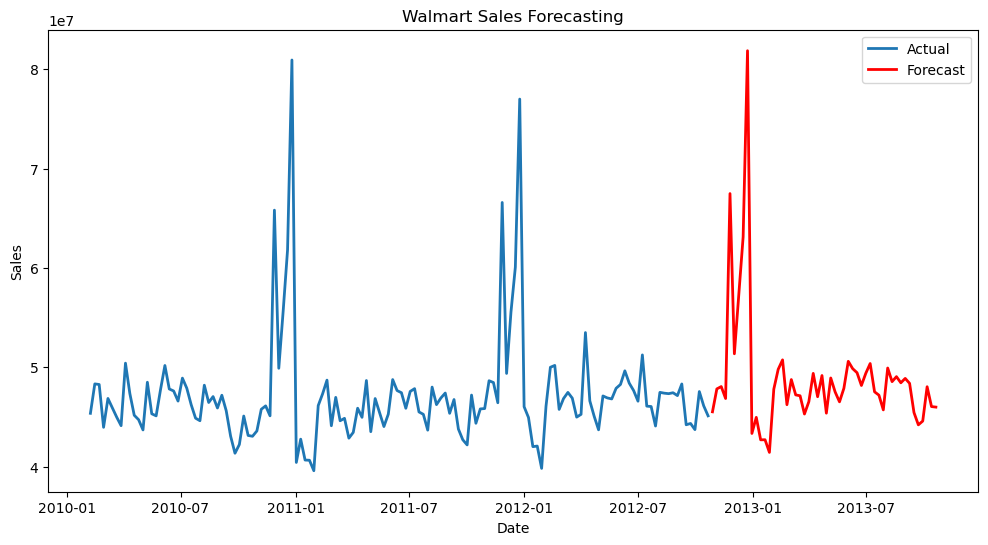

In [95]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Load Walmart data
df = pd.read_csv(r"E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\Cleaned\\Walmart_data_clean.csv")

# Ensure date column is datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop missing dates
df = df.dropna(subset=['Date'])

# Group by Date (weekly total sales)
df = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Sort by Date
df = df.sort_values('Date')

# Set date as index
df.set_index('Date', inplace=True)

# Ensure weekly frequency (fill missing weeks)
df = df.asfreq('W', method='ffill')

# Holt-Winters Model (weekly seasonality ~ 52 weeks)
model = ExponentialSmoothing(df['Weekly_Sales'], trend='add', seasonal='add', seasonal_periods=52)
fit = model.fit()

# Forecast next 52 weeks
forecast = fit.forecast(52)

# Plot
plt.figure(figsize=(12,6))
plt.plot(df['Weekly_Sales'], label='Actual', linewidth=2)
plt.plot(forecast, label='Forecast', color='red', linewidth=2)
plt.title("Walmart Sales Forecasting")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

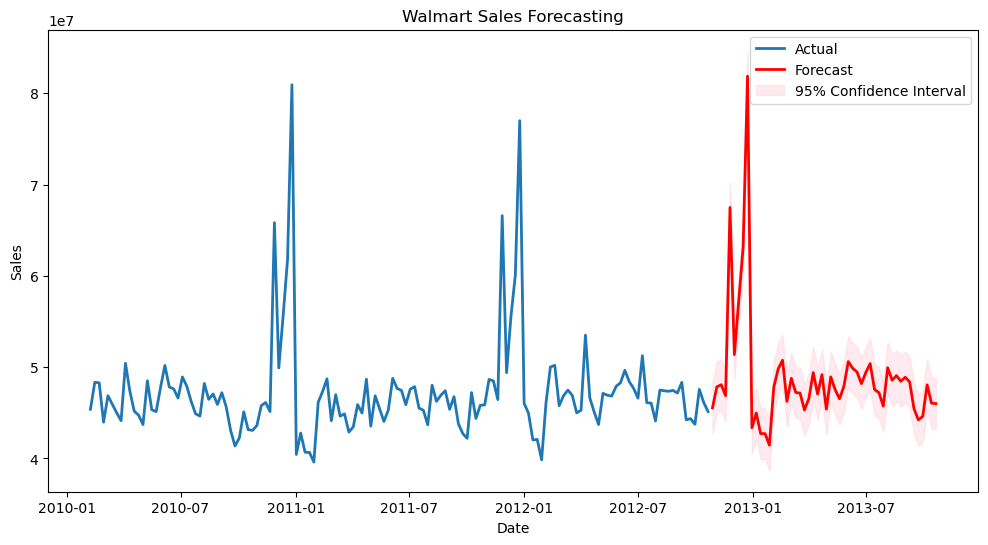

In [98]:
# Load data
df = pd.read_csv(r"E:\Major Projects\Retail Analytics Case Study\Data\Raw\Processed\Cleaned\\Walmart_data_clean.csv")

# Ensure datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

# Aggregate weekly sales
df = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Resample weekly (fill missing)
df = df.asfreq('W', method='ffill')

# Holt-Winters Model
model = ExponentialSmoothing(df['Weekly_Sales'], trend='add', seasonal='add', seasonal_periods=52)
fit = model.fit()

# Forecast next 52 weeks
forecast = fit.forecast(52)

# Plot
plt.figure(figsize=(12,6))
plt.plot(df['Weekly_Sales'], label='Actual', linewidth=2)
plt.plot(forecast, label='Forecast', color='red', linewidth=2)

# Add confidence interval (using ±1.96*std of residuals)
residuals = df['Weekly_Sales'] - fit.fittedvalues
std = residuals.std()
plt.fill_between(forecast.index, forecast - 1.96*std, forecast + 1.96*std,
                 color='pink', alpha=0.3, label="95% Confidence Interval")

plt.title("Walmart Sales Forecasting")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


### The blue line is your historical Walmart sales and the red line is your Holt-Winters forecast for the next 52 weeks.